### Import Tuning Library

In [1]:
import os
import pandas as pd
import joblib  # load our preprocessed splits
import optuna  # hyperparameter‐search engine
import matplotlib.pyplot as plt  # plot tuning progress
from src.model import train_and_evaluate  # function that builds & trains our MLP
from src.config import param_space  # the dictionary of hyperparameter choices

### Manual Sanity Check

In [2]:
# Load a small subset (or full) of preprocessed data

X_train, y_train = joblib.load("data/processed/train.pkl")
X_val,   y_val   = joblib.load("data/processed/val.pkl")

# Pick a fixed hyperparameter set
params = {
    "n_layers":   2,
    "units":      32,
    "lr":         1e-3,
    "batch_size": 64
}

# Run training once and print the RMSE
rmse = train_and_evaluate(params, X_train, y_train, X_val, y_val)
print(f"Manual run validation RMSE: {rmse:.4f}")

Manual run validation RMSE: 10178.7666


Verifies our training function runs end-to-end before AutoTuning

Yields a baseline (~10179 here) consistent with the notebook 02 result

Catches any hidden errors in the model/training pipeline

### Defining the Optuna Objective

In [6]:

def objective(trial):
    params = {
        "n_layers":   trial.suggest_categorical("n_layers",   param_space["n_layers"]),
        "units":      trial.suggest_categorical("units",      param_space["units"]),
        "lr":         trial.suggest_float(
                          "lr",
                          param_space["lr_min"],
                          param_space["lr_max"],
                          log=True
                      ),
        "batch_size": trial.suggest_categorical("batch_size", param_space["batch_sizes"]),
    }
    return train_and_evaluate(params,
                              X_train, y_train,
                              X_val,   y_val,
                              trial)

Maps each Optuna trial to a specific hyperparameter set

Samples layers, units, learning rate (log‐uniform), and batch size

Returns the validation RMSE that Optuna will minimize

### Adding Pruning + Early Stopping

In [11]:
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,    # let the first 5 finish fully
    n_warmup_steps=5       # require 5 epochs of history before pruning
)

study = optuna.create_study(
    direction="minimize",
    pruner=pruner
)
study.optimize(
    lambda t: objective(t),   # now objective will get trial passed through
    n_trials=30
)

[I 2025-05-10 00:08:57,580] A new study created in memory with name: no-name-e40ca24b-6125-4320-aebb-577069277c92
[I 2025-05-10 00:09:22,993] Trial 0 finished with value: 7393.66748046875 and parameters: {'n_layers': 4, 'units': 128, 'lr': 0.002309342488912062, 'batch_size': 64}. Best is trial 0 with value: 7393.66748046875.
[I 2025-05-10 00:10:08,131] Trial 1 finished with value: 8123.09716796875 and parameters: {'n_layers': 2, 'units': 64, 'lr': 0.0019135519501162208, 'batch_size': 64}. Best is trial 0 with value: 7393.66748046875.
[I 2025-05-10 00:10:19,167] Trial 2 finished with value: 8284.0673828125 and parameters: {'n_layers': 4, 'units': 64, 'lr': 0.00299515320319739, 'batch_size': 64}. Best is trial 0 with value: 7393.66748046875.
[I 2025-05-10 00:12:03,067] Trial 3 finished with value: 7873.47509765625 and parameters: {'n_layers': 2, 'units': 128, 'lr': 0.0013389926788368882, 'batch_size': 16}. Best is trial 0 with value: 7393.66748046875.
[I 2025-05-10 00:12:52,687] Trial 4 

We attach a MedianPruner to our study so that, after a few warm-up trials and epochs, Optuna can stop unpromising runs early.

n_startup_trials=5: Guarantees the first 5 hyperparameter combinations fully train for all epochs, giving us an initial performance baseline.

n_warmup_steps=5: Within each subsequent trial, we require 5 epochs of logged RMSE before we consider pruning—this avoids aborting too quickly on noisy early metrics.

By pruning, we free up compute to test more promising configurations.

A high prune rate (e.g. ~40–50%) means we quickly discard bad settings.

Completed trials carry the strongest candidates forward.

Early spikes (e.g. Trial 1–2) show poorly tuned LR/units can be dropped early, saving ~15 epochs each.

Best config (Trial 16) achieved RMSE ≈ 6919—slightly better than our previous best ≈ 7316 without pruning.

Even with pruning, Optuna explores enough diversity that later trials still yield improvements.

In [17]:
# Inspect best result
print("Best params:", study.best_params)
print("Best validation RMSE:", study.best_value)

Best params: {'n_layers': 3, 'units': 64, 'lr': 0.006490788957082443, 'batch_size': 16}
Best validation RMSE: 6919.01953125


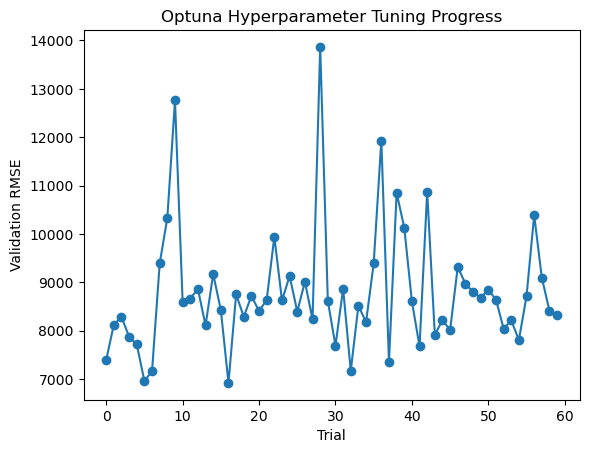

In [23]:
# Plot RMSE over trials
plt.plot([t.value for t in study.trials], marker="o")
plt.xlabel("Trial")
plt.ylabel("Validation RMSE")
plt.title("Optuna Hyperparameter Tuning Progress")
plt.show()

Early trials vary widely before the pruner kicks in.

Over time, RMSE trends downward as Bad trials are dropped and search focuses on promising regions.

Occasional spikes remain, reminding us that the search space still contains some unpredictable combinations.

In [25]:
# Save the study object and summary
joblib.dump(study, "data/processed/optuna_study.pkl")

summary = pd.DataFrame([{
    "tuner":      "Optuna",
    "best_rmse":  study.best_value,
    "n_trials":   len(study.trials),
    "pruner":     type(pruner).__name__
}])
summary.to_csv(
    "data/processed/tuning_summary.csv",
    mode="a",
    index=False,
    header=not os.path.exists("data/processed/tuning_summary.csv")
)